#**Code**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.4 MB/s eta 0:00:00


In [3]:
from tensorflow.keras.utils import img_to_array
from keras_preprocessing.image import load_img
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
import pandas as pd

In [4]:
image_dir = '/content/drive/MyDrive/CSE465/Dataset/mix weather'

# prompt the user to upload an image
from google.colab import files
uploaded = files.upload()

# retrieve the filename of the uploaded image
filename = next(iter(uploaded))

# define the path of the uploaded image
image_path = os.path.join(image_dir, filename)

# save the uploaded image to the image directory
with open(image_path, 'wb') as f:
    f.write(uploaded[filename])

Saving beatles.jpg to beatles.jpg


In [5]:
imgs_path = "/content/drive/MyDrive/CSE465/Dataset/mix weather/"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 10 # number of most similar images to retrieve

#**VGG16**

In [6]:
from keras.applications.vgg16 import VGG16
convlayer = VGG16(input_shape=(224,224,3),weights='imagenet', include_top=False)

model=Sequential()
model.add(convlayer)
model.add(Flatten())

model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [7]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("flatten").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [8]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("number of images:",len(files))
print(files)

number of images: 221
['/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1840.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1853.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1884.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1850.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1855.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weat

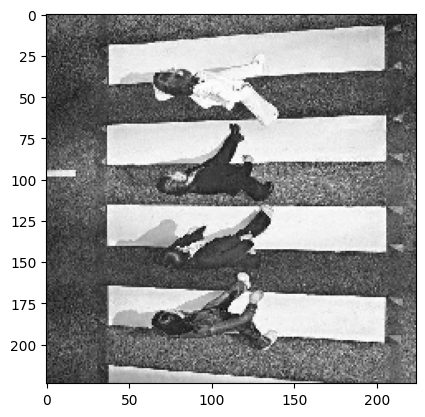

image loaded successfully!


In [9]:
original = load_img(files[-1], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [10]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the RESNET model
processed_image = preprocess_input(image_batch.copy())


image batch size (1, 224, 224, 3)


In [11]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 9s 9s/step
features successfully extracted!
number of image features: 25088


array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [13]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

7/7 [==============================] - 9s 700ms/step
features successfully extracted!


(221, 25088)

#**Cosine Similarity**

In [14]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

print(cosSimilarities)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

[[1.0000004  0.17361706 0.16494851 ... 0.08146035 0.12148333 0.07443406]
 [0.17361706 1.         0.19629562 ... 0.07999356 0.0562895  0.04730522]
 [0.16494851 0.19629562 0.9999998  ... 0.10180486 0.0621801  0.0427147 ]
 ...
 [0.08146035 0.07999356 0.10180486 ... 1.         0.13114944 0.09389487]
 [0.12148333 0.0562895  0.0621801  ... 0.13114944 1.0000007  0.09904715]
 [0.07443406 0.04730522 0.0427147  ... 0.09389487 0.09904715 0.9999999 ]]


,/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg,...,/content/drive/MyDrive/CSE465/Dataset/mix weather/0852.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0879.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0883.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0854.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0844.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0849.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0858.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/beatles.jpg
/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,1.000000,0.173617,0.164949,0.155457,0.171719,0.162136,0.201007,0.201134,0.170228,0.189761,...,0.105846,0.057224,0.121191,0.077369,0.056262,0.075291,0.142645,0.081460,0.121483,0.074434
/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,0.173617,1.000000,0.196296,0.191915,0.228926,0.137312,0.170158,0.230128,0.176989,0.150658,...,0.084039,0.055920,0.144690,0.051031,0.069899,0.049793,0.104045,0.079994,0.056289,0.047305
/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,0.164949,0.196296,1.000000,0.429755,0.176471,0.210758,0.288720,0.202096,0.197413,0.294067,...,0.099604,0.047512,0.131440,0.071173,0.115157,0.053337,0.131652,0.101805,0.062180,0.042715
/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,0.155457,0.191915,0.429755,1.000000,0.136922,0.269162,0.346879,0.205918,0.220466,0.259023,...,0.101891,0.073110,0.117929,0.057261,0.123989,0.052844,0.195755,0.125130,0.054417,0.055304
/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,0.171719,0.228926,0.176471,0.136922,1.000000,0.185861,0.250561,0.306521,0.192137,0.205259,...,0.097056,0.047120,0.141263,0.063935,0.065696,0.060343,0.142771,0.092594,0.053778,0.086641


In [15]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])





In [16]:
retrieve_most_similar_products(files[-1])

Output hidden; open in https://colab.research.google.com to view.

#**Euclidian Distance**

In [17]:
from sklearn.metrics.pairwise import pairwise_distances

# compute Euclidean distances between image features
euclidean_distances = pairwise_distances(imgs_features, metric='euclidean')

print(euclidean_distances)
euclidean_distances_df = pd.DataFrame(euclidean_distances, columns=files, index=files)
euclidean_distances_df.head()

[[   0.     1323.9686 1535.5582 ... 2493.1372 2070.0042 1682.2408]
 [1323.9686    0.     1327.6937 ... 2383.8838 1994.0143 1513.8293]
 [1535.5582 1327.6937    0.     ... 2481.4062 2144.972  1728.4281]
 ...
 [2493.1372 2383.8838 2481.4062 ...    0.     2755.5598 2528.559 ]
 [2070.0042 1994.0143 2144.972  ... 2755.5598    0.     2152.9714]
 [1682.2408 1513.8293 1728.4281 ... 2528.559  2152.9714    0.    ]]


,/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg,...,/content/drive/MyDrive/CSE465/Dataset/mix weather/0852.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0879.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0883.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0854.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0844.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0849.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0858.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/beatles.jpg
/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,0.000000,1323.968628,1535.558228,1661.612427,1427.381836,1542.617676,1456.301270,1774.956543,1386.221313,1527.696655,...,1854.447144,1762.464966,1421.838867,1378.762939,2098.399902,1534.345825,1344.478516,2493.137207,2070.004150,1682.240845
/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,1323.968628,0.000000,1327.693726,1467.886597,1179.990479,1377.591553,1291.245605,1618.726318,1164.841064,1380.630493,...,1715.883545,1581.217041,1182.553955,1148.096558,1940.905151,1339.105713,1131.610840,2383.883789,1994.014282,1513.829346
/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,1535.558228,1327.693726,0.000000,1381.710449,1442.218750,1513.915649,1390.929565,1787.069092,1383.439453,1441.646729,...,1875.511230,1788.384155,1433.825806,1404.914795,2050.901367,1571.882690,1373.838135,2481.406250,2144.971924,1728.428101
/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,1661.612427,1467.886597,1381.710449,0.000000,1602.696045,1565.235107,1442.898926,1872.450562,1492.210327,1584.877930,...,1973.084717,1875.430298,1576.998291,1556.799072,2128.378662,1700.322266,1462.816040,2523.715820,2244.895508,1833.665894
/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,1427.381836,1179.990479,1442.218750,1602.696045,0.000000,1438.870117,1327.939575,1608.524048,1272.481567,1433.404907,...,1791.464478,1689.191162,1307.665771,1279.671143,2022.918457,1451.337524,1239.667725,2431.133789,2074.463623,1587.441406


In [18]:
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = euclidean_distances_df[given_img].sort_values()[1:nb_closest_images+1].index
    closest_imgs_scores = euclidean_distances_df[given_img].sort_values()[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("Euclidian distance : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


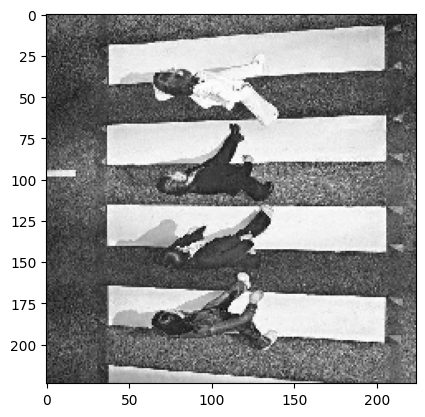

-----------------------------------------------------------------------
most similar products:


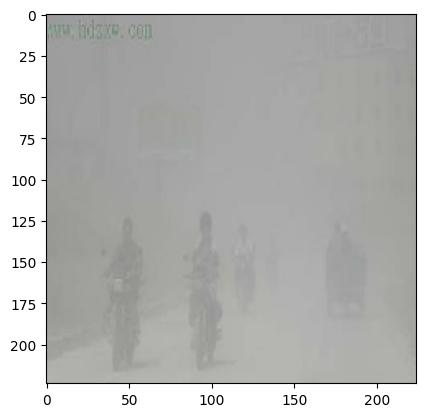

Euclidian distance :  1306.2817


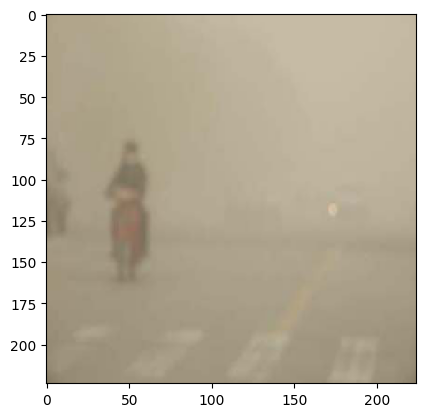

Euclidian distance :  1312.0801


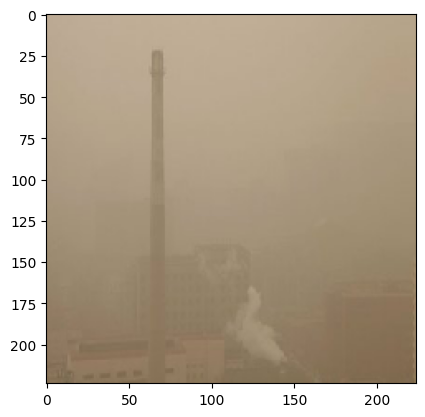

Euclidian distance :  1320.2112


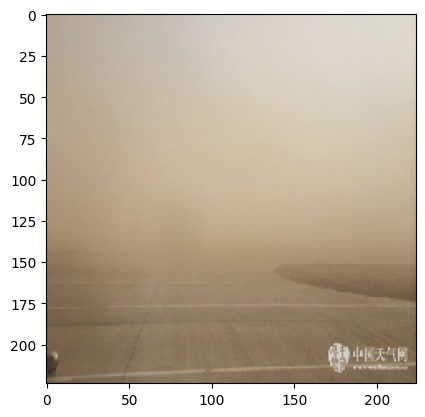

Euclidian distance :  1326.0864


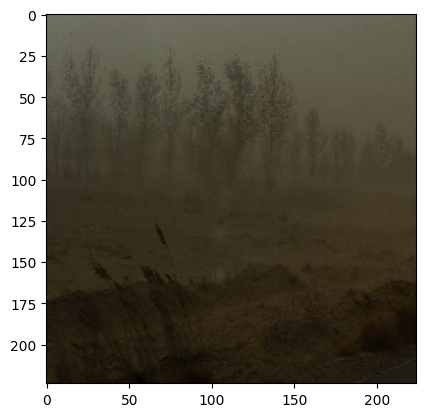

Euclidian distance :  1331.5056


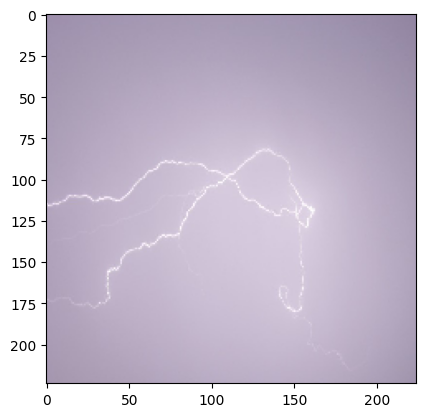

Euclidian distance :  1339.3322


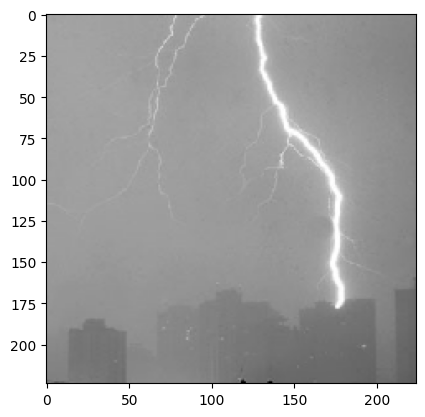

Euclidian distance :  1349.0586


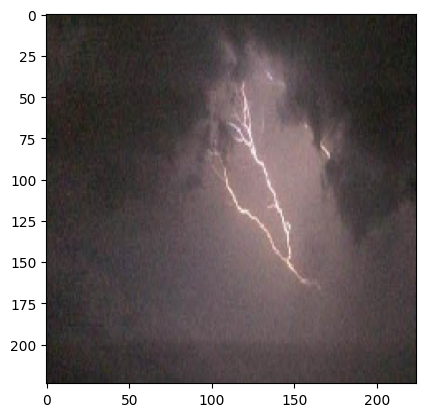

Euclidian distance :  1349.3948


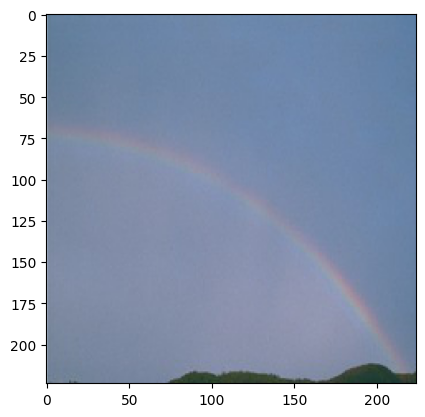

Euclidian distance :  1350.5577


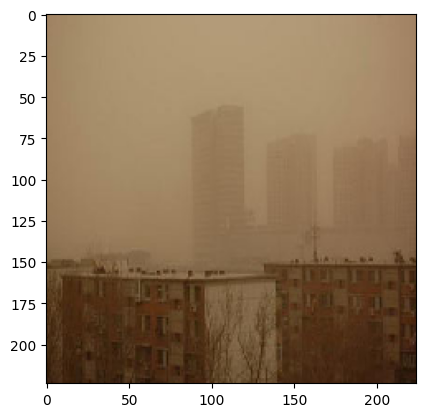

Euclidian distance :  1355.1198


In [19]:
retrieve_most_similar_products(files[-1])